<a href="https://colab.research.google.com/github/Nguyendai202/Computer-vision/blob/main/camera___calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import thư viện 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import glob
import os 
import matplotlib.pyplot as plt
import math

Show checkerboard 

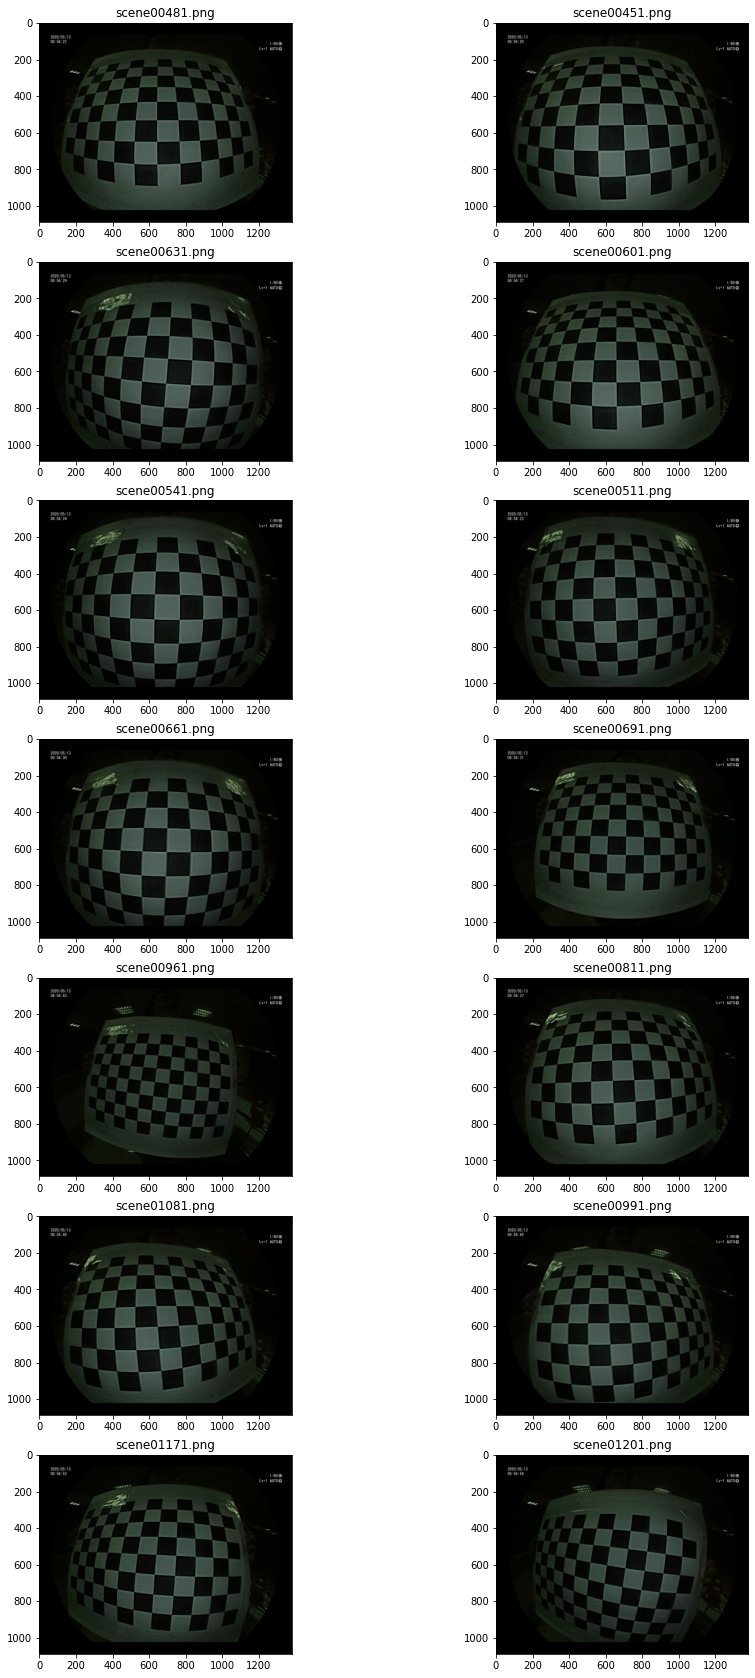

In [ ]:
images=glob.glob('/content/drive/MyDrive/Computer_vision/B3/chessboard/*.png')
column=2
row=int(math.ceil(len(images)/column))
column, row
plt.figure(figsize=(15,30))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))

 termination criteria : 
 Trong quá trình xác định tham số trong ta setup sai số và số vòng lặp khi sử dụng thuật toán 

Checkerboard chúng ta dùng 12x8 . Nhưng setup 11x7 vì chúng ta không muốn lấy tham số horner ngoài cùng các đường biên 

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,100,0.01)
cb_row = 11
cb_column = 7 

In [ ]:
# setup toạ độ thế giới thực chứa gắn vào mảng 2D 
# mỗi hàng trong mảng objword tương ứng với một phần tử trong lưới hình chữ nhật và
# chứa hai giá trị là chỉ số hàng và chỉ số cột tương ứng của phần tử đó trong lưới hình chữ nhật.
#  Giá trị của cột thứ ba trong mỗi hàng được khởi tạo là 0
# mỗi một ô vuông là có 1 điểm toạ độ gồm 3 chỉ số tương ứng (77x3)
objworld = np.zeros((cb_row*cb_column,3),np.float32)# obj 3D
objworld[:,:2] = np.mgrid[0:cb_row,0:cb_column].T.reshape(-1,2) # hàm chia lưới 
objworld
objworld.shape

(77, 3)

In [ ]:
# Mảng đề lưu object points và image points từ toàn bộ các ảnh đảm bảo 2 mảng này có cùng kích thước
worldpoints = []  # lưu trữ tọa độ 3d trong không gian thế giới thực (3d point in real world space)
imgpoints = []   # Lưu tọa độ 2D trên ảnh (2d point in image plane)

['/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00481.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00451.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00631.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00601.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00541.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00511.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00661.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00691.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00961.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00811.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene01081.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00991.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene01171.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene01201.png']


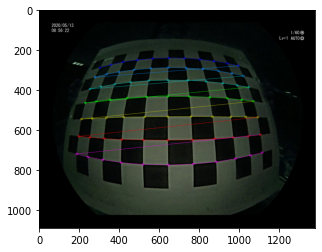

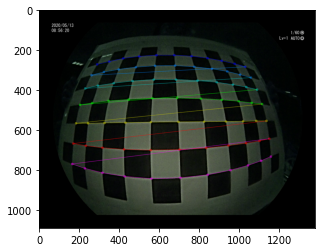

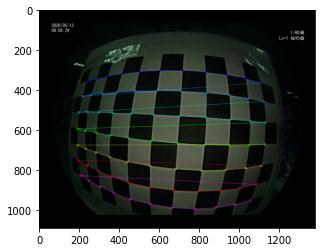

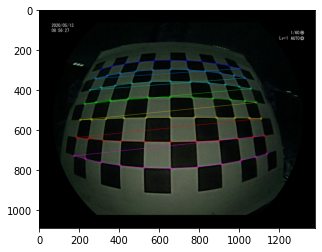

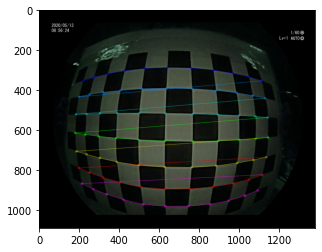

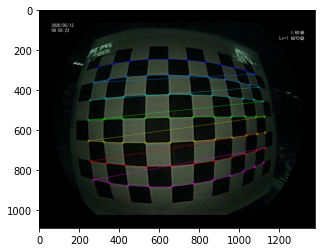

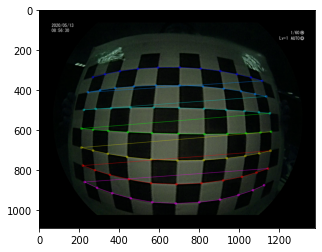

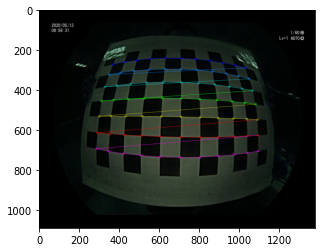

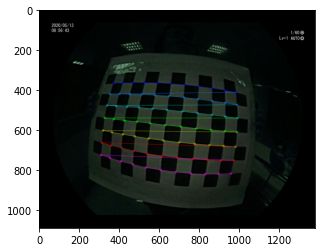

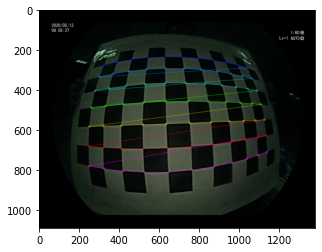

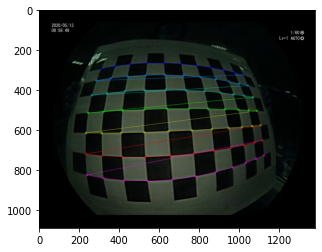

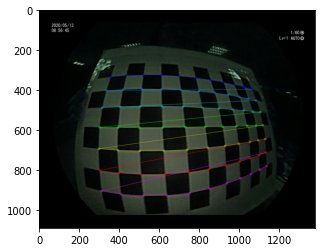

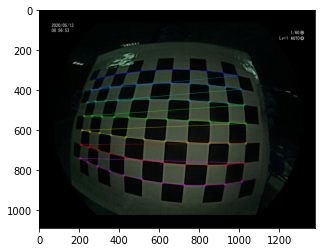

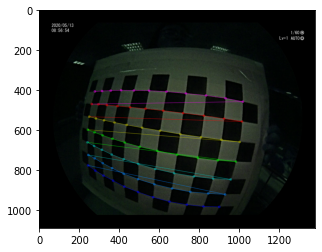

In [ ]:
images = glob.glob('/content/drive/MyDrive/Computer_vision/B3/chessboard/*.png')
print(images) 
i=0
for fname in images :
  i=i+1
  img = cv2.imread(fname)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, corners = cv2.findChessboardCorners(gray, (cb_row, cb_column), flags=cv2.CALIB_CB_FILTER_QUADS + cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK)
  if ret == True:
      newCorners = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)# tinh chỉnh lại corners
      imgpoints.append(newCorners)
      worldpoints.append(objworld)# toạ độ do ta thiết lập ở trên kia 
      img = cv2.drawChessboardCorners(img,(cb_row,cb_column),newCorners,ret) # show corners in image
      plt.imshow(img)
      plt.show()
  else : 
    os.remove(fname)



calibration Camera 

In [ ]:
#tiến hành hiệu chỉnh để tìm các tham số  
ret , para_intrisics , dist , rvecs , tvecs = cv2.calibrateCamera(worldpoints,imgpoints,gray.shape[::-1],None,None,flags = cv2.CALIB_RATIONAL_MODEL)
dist = np.array(dist)


đầu ra của para_instrics : ( tham số trong ) 

Vd : fx = 573.07233242, f =1 

dist  = k1,k2,p1,p2,k3,k4,k5,k6 ( tham số dùng để sửa méo ) 
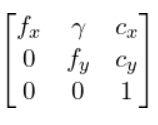

In [ ]:
print(ret)# sai số 
print('-----')
print(para_intrisics)
print('-----')
print(dist)

1.8804342521372825
-----
[[573.07233227   0.         679.10106207]
 [  0.         574.45187239 562.38070642]
 [  0.           0.           1.        ]]
-----
[[-1.66119900e+00  4.96469311e+00 -9.71579801e-04 -1.09742864e-03
   7.16046975e-01 -1.27661699e+00  4.33645008e+00  2.59282477e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


Sau khi có được các tham số thì chúng ta tiến hành tối ưu ,thiết lập thêm tham số và khử méo nhờ vào các tham số méo 

In [ ]:
img1 = cv2.imread("/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00451.png")
h , w = img1.shape[:2]# chuyển về 2 chiều 
newcameraintrics,roi = cv2.getOptimalNewCameraMatrix(para_intrisics,dist,(w,h),0,(w,h))# tối ưu tham số và thiết lập anpha 

In [ ]:
#Cách thứ nhất 
dst = cv2.undistort(img1,para_intrisics,dist,None,newcameraintrics)
x,y,w,h = roi
dst = dst [y:y+h,x:x+w]
cv2.imwrite('calibration_result2.png',dst)

True

In [ ]:
from numpy.ma.core import mean
img1 = cv2.imread("/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00451.png")
h , w = img1.shape[:2]# chuyển về 2 chiều 
newcameraintrics,roi = cv2.getOptimalNewCameraMatrix(para_intrisics,dist,(w,h),1,(w,h))# tối ưu tham số và thiết lập anpha 
resultImg = glob.glob("/content/drive/MyDrive/Computer_vision/B3/chessboard/*.png")
print(resultImg) 
for resuImg in resultImg:
  img = cv2.imread(resuImg)
  # Cách thứ 2  ( biến đổi tuyến tính)
  mapx,mapy = cv2.initUndistortRectifyMap(para_intrisics,dist,None,newcameraintrics,(w,h),5)
  dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)
  # write result
  path ="/content/drive/MyDrive/Computer_vision/B3/chessboard/result/Calibra_"+ os.path.basename(resuImg)
  cv2.imwrite(path,dst)
# check error
mean_error = 0
for i in range(len(worldpoints)):
  newImgpoints, _ = cv2.projectPoints(worldpoints[i],rvecs[i],tvecs[i],para_intrisics,dist)
  error = cv2.norm(imgpoints[i],newImgpoints,cv2.NORM_L2)/len(newImgpoints)
  mean_error += error
  print("total error",mean_error/len(worldpoints))




['/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00481.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00451.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00631.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00601.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00541.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00511.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00661.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00691.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00961.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00811.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene01081.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene00991.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene01171.png', '/content/drive/MyDrive/Computer_vision/B3/chessboard/scene01201.png']
total

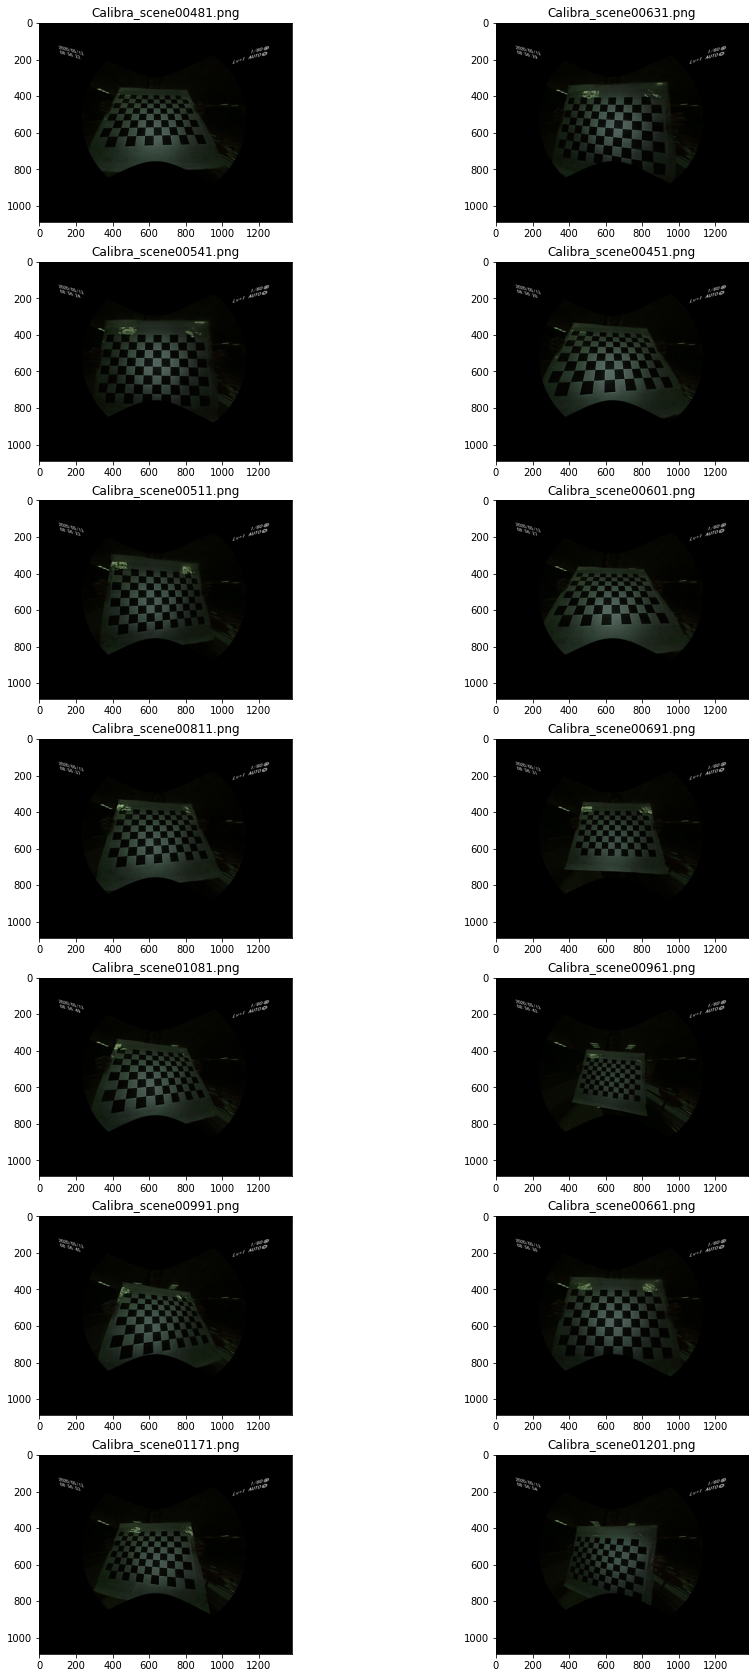

In [ ]:
# kết quả 
images=glob.glob('/content/drive/MyDrive/Computer_vision/B3/chessboard/result/*.png')
column=2
row=int(math.ceil(len(images)/column))
column, row
plt.figure(figsize=(15,30))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))

Sau khi chúng ta đã có bộ tham số trong ở bên trên từ việc hiệu chỉnh với checkerboard thì chúng ta sẽ dùng bộ tham số này để sửa méo ảnh trong nội soi 

showdata 

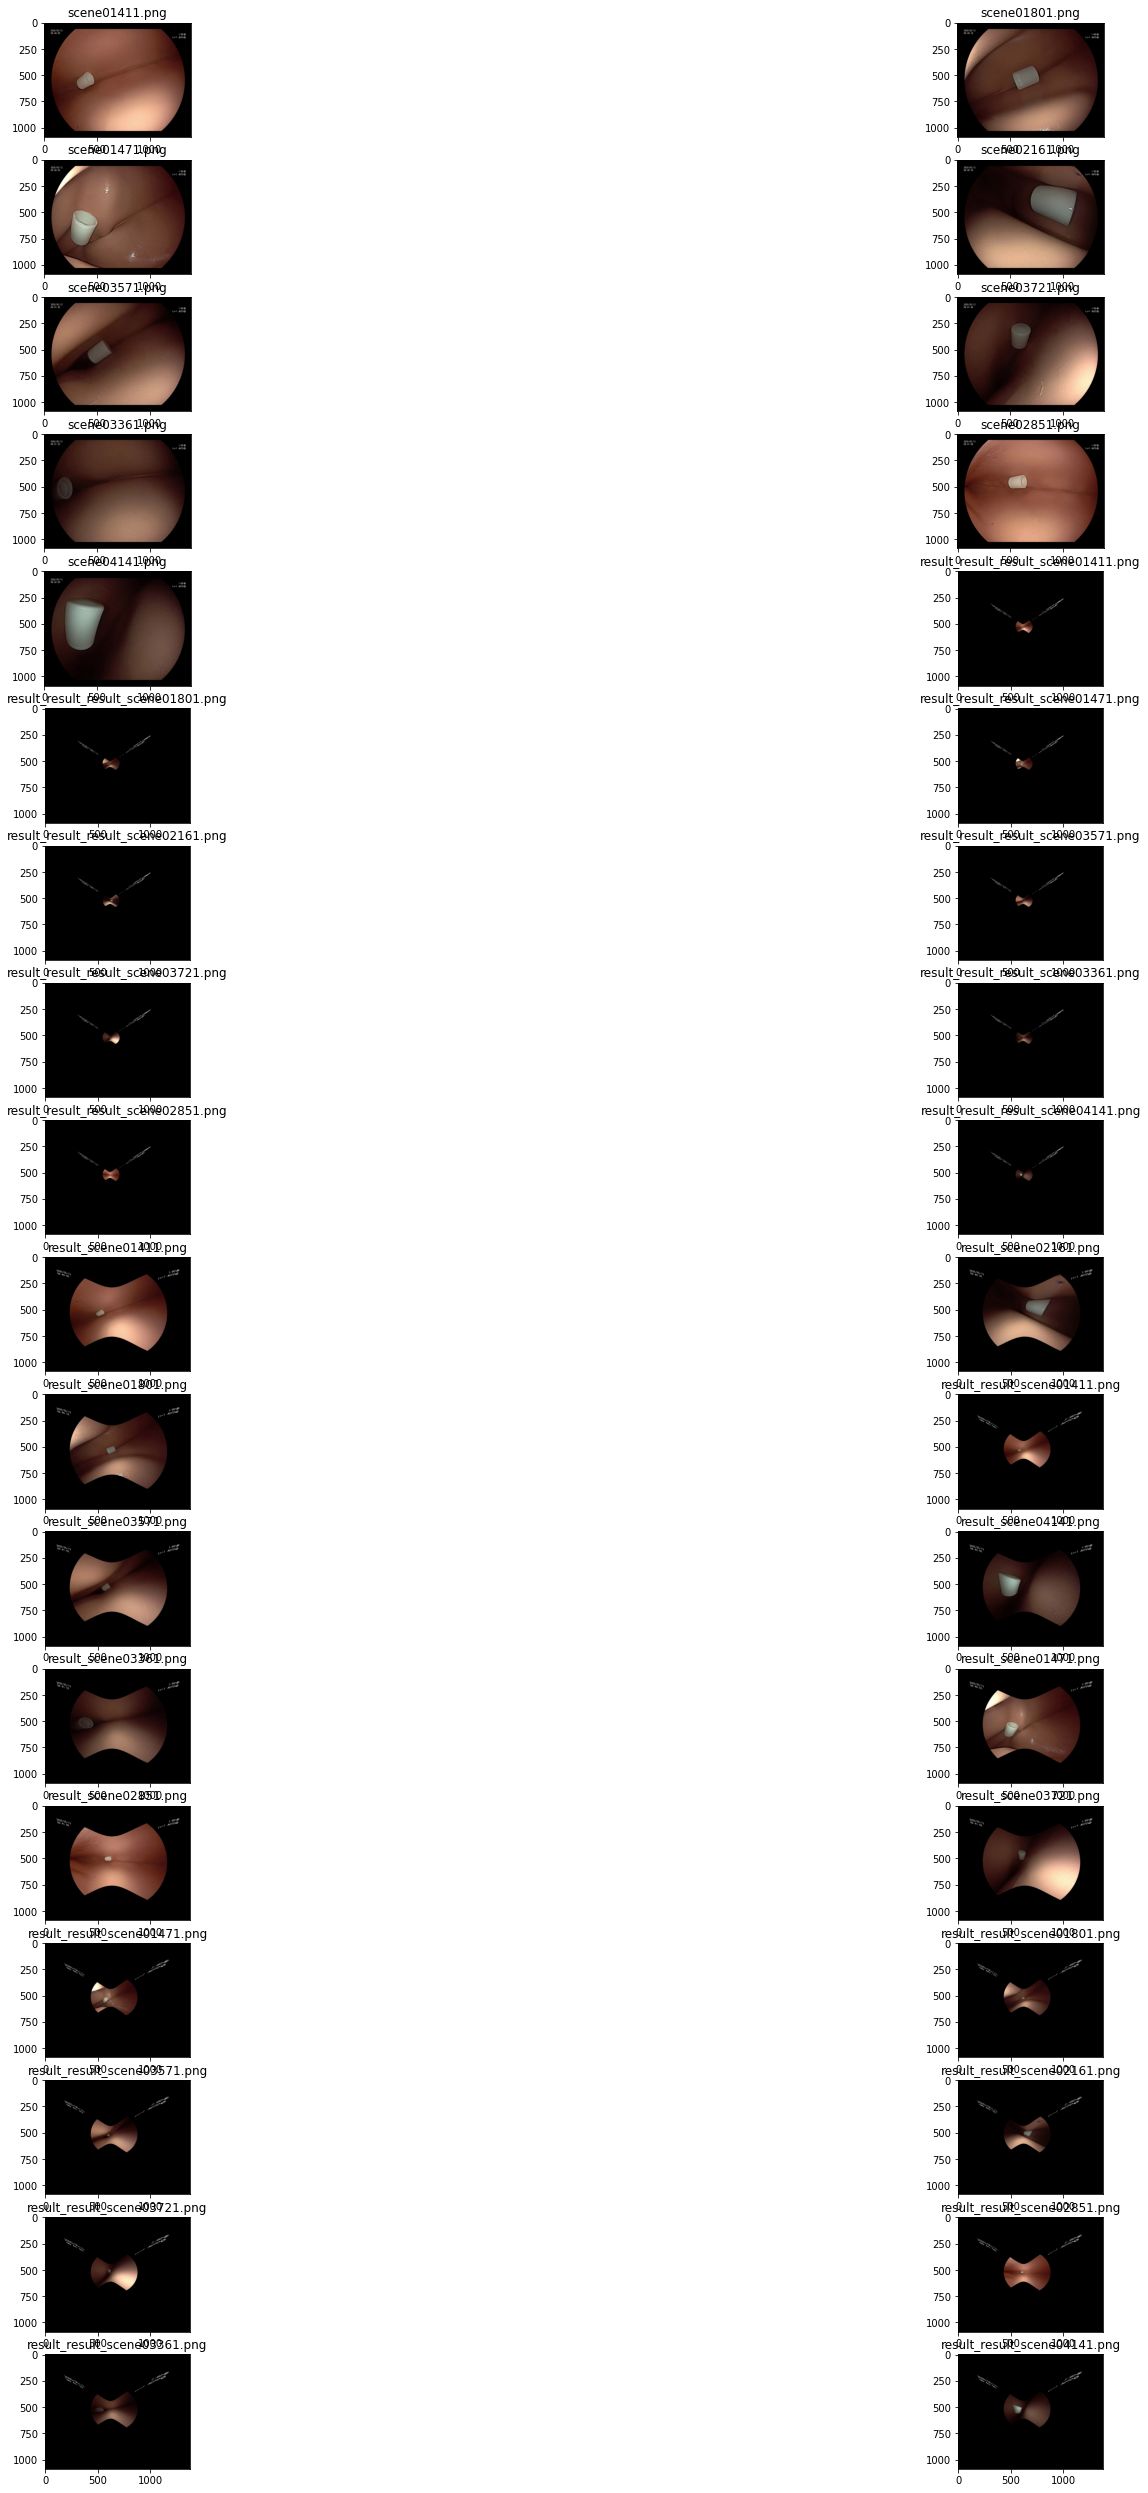

In [ ]:
images=glob.glob('/content/drive/MyDrive/Computer_vision/B3/Scenes/*.png')
column=2
row=int(math.ceil(len(images)/column))
column, row 
plt.figure(figsize=(30,45))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))

Thực hiện hiểu chỉnh sửa méo giúp cho việc quan sát vật thể dễ hơn 

In [ ]:


newcameraintrics,roi = cv2.getOptimalNewCameraMatrix(para_intrisics,dist,(w,h),1,(w,h))# tối ưu tham số và thiết lập anpha 
resultImg = glob.glob("/content/drive/MyDrive/Computer_vision/B3/Scenes/*.png")
for resuImg in resultImg:
  img = cv2.imread(resuImg)
  # C2 ( biến đổi tuyến tính)
  mapx,mapy = cv2.initUndistortRectifyMap(para_intrisics,dist,None,newcameraintrics,(w,h),5)
  dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)
  # write result
  path ="/content/drive/MyDrive/Computer_vision/B3/Scenes/result_"+ os.path.basename(resuImg)
  cv2.imwrite(path,dst)
# check error
mean_error = 0
for i in range(len(worldpoints)):
  newImgpoints, _ = cv2.projectPoints(worldpoints[i],rvecs[i],tvecs[i],para_intrisics,dist)
  error = cv2.norm(imgpoints[i],newImgpoints,cv2.NORM_L2)/len(newImgpoints)
  mean_error += error
  print("total error",mean_error/len(worldpoints))


total error 0.015164671235684808
total error 0.03254968697331546
total error 0.04888403078003223
total error 0.06549737783499122
total error 0.08048992628784699
total error 0.09484812453037318
total error 0.11323366841456685
total error 0.12601000026283032
total error 0.13584939418107891
total error 0.15196762929356336
total error 0.1672640180382484
total error 0.18500492141653943
total error 0.19698906762571403
total error 0.2119560554821198


So sánh ảnh gốc và sau khi chỉnh méo 

Ta thấy rằng ảnh đã phẳng hơn và mắt gốc chụp đã xa ra > giúp cho việc quan sát vật thể dễ dàng hơn 

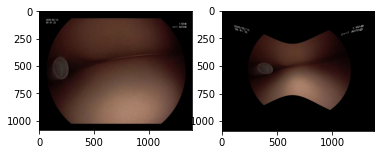

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Computer_vision/B3/Scenes/scene03361.png",cv2.IMREAD_COLOR)
img_ori = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
img2 = cv2.imread("/content/drive/MyDrive/Computer_vision/B3/Scenes/result_scene03361.png",cv2.IMREAD_COLOR)
img_result = cv2.cvtColor(img2,cv2.COLOR_RGB2BGR)
fix , ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img_ori,)
ax[1].imshow(img_result) 
plt.show() 
